In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
## Imports
import warnings
warnings.filterwarnings('ignore')

import sys

if "google.colab" in sys.modules:
    !pip uninstall lightgbm -y
    !pip install lightgbm==3.3.1
    !pip install Levenshtein

import os
import gc
import time
import random
import pickle
import Levenshtein
import difflib
import multiprocessing
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import lightgbm as lgb
from tqdm.auto import tqdm
from requests import get
from collections import Counter, defaultdict
from sklearn.model_selection import GroupKFold, StratifiedKFold
from sklearn.neighbors import KNeighborsRegressor
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestNeighbors

Found existing installation: lightgbm 2.2.3
Uninstalling lightgbm-2.2.3:
  Successfully uninstalled lightgbm-2.2.3
     |████████████████████████████████| 2.0 MB 27.5 MB/s 
     |████████████████████████████████| 258 kB 23.3 MB/s 
     |████████████████████████████████| 1.8 MB 57.5 MB/s 
     |████████████████████████████████| 103 kB 78.0 MB/s 


In [ ]:
def stratified_group_k_fold(X, y, groups, k, seed=None):
    labels_num = np.max(y) + 1
    y_counts_per_group = defaultdict(lambda: np.zeros(labels_num))
    y_distr = Counter()
    for label, g in zip(y, groups):
        y_counts_per_group[g][label] += 1
        y_distr[label] += 1

    y_counts_per_fold = defaultdict(lambda: np.zeros(labels_num))
    groups_per_fold = defaultdict(set)

    def eval_y_counts_per_fold(y_counts, fold):
        y_counts_per_fold[fold] += y_counts
        std_per_label = []
        for label in range(labels_num):
            label_std = np.std([y_counts_per_fold[i][label] / y_distr[label] for i in range(k)])
            std_per_label.append(label_std)
        y_counts_per_fold[fold] -= y_counts
        return np.mean(std_per_label)
    
    groups_and_y_counts = list(y_counts_per_group.items())
    random.Random(seed).shuffle(groups_and_y_counts)

    for g, y_counts in sorted(groups_and_y_counts, key=lambda x: -np.std(x[1])):
        best_fold = None
        min_eval = None
        for i in range(k):
            fold_eval = eval_y_counts_per_fold(y_counts, i)
            if min_eval is None or fold_eval < min_eval:
                min_eval = fold_eval
                best_fold = i
        y_counts_per_fold[best_fold] += y_counts
        groups_per_fold[best_fold].add(g)

    all_groups = set(groups)
    for i in range(k):
        train_groups = all_groups - groups_per_fold[i]
        test_groups = groups_per_fold[i]

        train_indices = [i for i, g in enumerate(groups) if g in train_groups]
        test_indices = [i for i, g in enumerate(groups) if g in test_groups]

        yield train_indices, test_indices

In [ ]:
def get_distribution(y_vals):
    y_distr = Counter(y_vals)
    y_vals_sum = sum(y_distr.values())
    return [f'{y_distr[i] / y_vals_sum:.2%}' for i in range(np.max(y_vals) + 1)]

In [ ]:
## Parameters
class CFG:
    AUTHOR = "kuruton"
    expID = ""
    if "google.colab" in sys.modules:
        expID = get("http://172.28.0.2:9000/api/sessions").json()[0]["name"].split(".")[0].split("-")[0]
    ROOT_DIR = '/content/drive/MyDrive/Kaggle/Foursquare'
    DATASET_DIR = os.path.join(ROOT_DIR, 'Dataset')
    INPUT_DIR = os.path.join(ROOT_DIR, 'Input')
    OUTPUT_DIR = os.path.join(ROOT_DIR, 'Output')
    is_debug = False
    SEED = 2022
    num_neighbors = 20
    num_split = 5
    n_geographic_split = 48
    feat_columns = ['name', 'address', 'city', 
                'state', 'zip', 'url', 
              'phone', 'categories', 'country']
    vec_columns = ['name', 'categories', 'address', 
                  'state', 'url', 'country']

def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    
seed_everything(CFG.SEED)

In [ ]:
if not os.path.exists(os.path.join(CFG.OUTPUT_DIR, CFG.expID)):
    os.makedirs(os.path.join(CFG.OUTPUT_DIR, CFG.expID))

In [ ]:
%load_ext Cython

In [ ]:
%%cython
def LCS(str S, str T):
    cdef int i, j
    cdef list dp = [[0] * (len(T) + 1) for _ in range(len(S) + 1)]
    for i in range(len(S)):
        for j in range(len(T)):
            dp[i + 1][j + 1] = max(dp[i][j] + (S[i] == T[j]), dp[i + 1][j], dp[i][j + 1], dp[i + 1][j + 1])
    return dp[len(S)][len(T)]

In [ ]:
def recall_knn(df, Neighbors = 10):
    print('Start knn grouped by country')
    train_df_country = []
    for country, country_df in tqdm(df.groupby('latlon_section')):
        country_df = country_df.reset_index(drop = True)

        neighbors = min(len(country_df), Neighbors)
        knn = KNeighborsRegressor(n_neighbors = neighbors,
                                    metric = 'haversine',
                                    n_jobs = -1)
        knn.fit(country_df[['latitude','longitude']], country_df.index)
        dists, nears = knn.kneighbors(country_df[['latitude', 'longitude']], 
                                        return_distance = True)

        for k in range(neighbors):            
            cur_df = country_df[['id']]
            cur_df['match_id'] = country_df['id'].values[nears[:, k]]
            cur_df['kdist_country'] = dists[:, k]
            cur_df['kneighbors_country'] = k
            
            train_df_country.append(cur_df)
    train_df_country = pd.concat(train_df_country)
    
    print('Start knn')
    train_df = []
    knn = NearestNeighbors(n_neighbors = Neighbors)
    knn.fit(df[['latitude','longitude']], df.index)
    dists, nears = knn.kneighbors(df[['latitude','longitude']])
    
    for k in range(Neighbors):            
        cur_df = df[['id']]
        cur_df['match_id'] = df['id'].values[nears[:, k]]
        cur_df['kdist'] = dists[:, k]
        cur_df['kneighbors'] = k
        train_df.append(cur_df)
    
    train_df = pd.concat(train_df)
    train_df = train_df.merge(train_df_country,
                                 on = ['id', 'match_id'],
                                 how = 'outer')
    del train_df_country
    
    return train_df

In [ ]:
def add_features(df):    
    for col in tqdm(CFG.feat_columns):       
        if col in CFG.vec_columns:
            tv_fit = tfidf_d[col]
            indexs = [id2index_d[i] for i in df['id']]
            match_indexs = [id2index_d[i] for i in df['match_id']]                    
            df[f'{col}_sim'] = tv_fit[indexs].multiply(tv_fit[match_indexs]).sum(axis = 1).A.ravel()
        
        col_values = data.loc[df['id']][col].values.astype(str)
        matcol_values = data.loc[df['match_id']][col].values.astype(str)
        
        geshs = []
        levens = []
        jaros = []
        lcss = []
        for s, match_s in zip(col_values, matcol_values):
            if s != 'nan' and match_s != 'nan':                    
                geshs.append(difflib.SequenceMatcher(None, s, match_s).ratio())
                levens.append(Levenshtein.distance(s, match_s))
                jaros.append(Levenshtein.jaro_winkler(s, match_s))
                lcss.append(LCS(str(s), str(match_s)))
            else:
                geshs.append(np.nan)
                levens.append(np.nan)
                jaros.append(np.nan)
                lcss.append(np.nan)
        
        df[f'{col}_gesh'] = geshs
        df[f'{col}_leven'] = levens
        df[f'{col}_jaro'] = jaros
        df[f'{col}_lcs'] = lcss
        
        if col not in ['phone', 'zip']:
            df[f'{col}_len'] = list(map(len, col_values))
            df[f'match_{col}_len'] = list(map(len, matcol_values)) 
            df[f'{col}_len_diff'] = np.abs(df[f'{col}_len'] - df[f'match_{col}_len'])
            df[f'{col}_nleven'] = df[f'{col}_leven'] / \
                                    df[[f'{col}_len', f'match_{col}_len']].max(axis = 1)
            
            df[f'{col}_nlcsk'] = df[f'{col}_lcs'] / df[f'match_{col}_len']
            df[f'{col}_nlcs'] = df[f'{col}_lcs'] / df[f'{col}_len']
            
            df = df.drop(f'{col}_len', axis = 1)
            df = df.drop(f'match_{col}_len', axis = 1)
            gc.collect()
            
    return df

In [ ]:
def get_id2poi(input_df: pd.DataFrame) -> dict:
    return dict(zip(input_df['id'], input_df['point_of_interest']))

def get_poi2ids(input_df: pd.DataFrame) -> dict:
    return input_df.groupby('point_of_interest')['id'].apply(set).to_dict()

def get_score(input_df: pd.DataFrame):
    scores = []
    for id_str, matches in zip(input_df['id'].to_numpy(), input_df['matches'].to_numpy()):
        targets = poi2ids[id2poi[id_str]]
        preds = set(matches.split())
        score = len((targets & preds)) / len((targets | preds))
        scores.append(score)
    scores = np.array(scores)
    return scores.mean()

def analysis(df):
    print('Num of data: %s' % len(df))
    print('Num of unique id: %s' % df['id'].nunique())
    print('Num of unique poi: %s' % df['point_of_interest'].nunique())
    
    poi_grouped = df.groupby('point_of_interest')['id'].count().reset_index()
    print('Mean num of unique poi: %s' % poi_grouped['id'].mean())

In [ ]:
## Data load
if "google.colab" in sys.modules:
    data_root = CFG.INPUT_DIR
else:
    data_root = '../input/foursquare-location-matching'
data = pd.read_csv(os.path.join(data_root, 'train.csv'))

if CFG.is_debug:
    data = data.sample(n = 10000, random_state = CFG.SEED)
    data = data.reset_index(drop = True)

In [ ]:
## Data split
kf = GroupKFold(n_splits=2)
for i, (trn_idx, val_idx) in enumerate(kf.split(data, 
                                                data['point_of_interest'], 
                                                data['point_of_interest'])):
    data.loc[val_idx, 'set'] = i

print('Num of train data: %s' % len(data))
print(data['set'].value_counts())

valid_data = data[data['set'] == 0]
train_data = data[data['set'] == 1]

print('Train data: ')
analysis(train_data)
print('Valid data: ')
analysis(valid_data)

train_poi = train_data['point_of_interest'].unique().tolist()
valid_poi = valid_data['point_of_interest'].unique().tolist()

print(set(train_poi) & set(valid_poi))

train_ids = train_data['id'].unique().tolist()
valid_ids = valid_data['id'].unique().tolist()
      
print(set(train_ids) & set(valid_ids))
      
tv_ids_d = {}
tv_ids_d['train_ids'] = train_ids
tv_ids_d['valid_ids'] = valid_ids

np.save('tv_ids_d.npy', tv_ids_d)

del train_data, valid_data
gc.collect()

data = data.set_index('id')
data = data.loc[tv_ids_d['train_ids']]
data = data.reset_index()

Num of train data: 1138812
1.0    569406
0.0    569406
Name: set, dtype: int64
Train data: 
Num of data: 569406
Num of unique id: 569406
Num of unique poi: 369987
Mean num of unique poi: 1.5389892077289202
Valid data: 
Num of data: 569406
Num of unique id: 569406
Num of unique poi: 369985
Mean num of unique poi: 1.5389975269267673
set()
set()


#Add new geographic coordinate classification

In [ ]:
latitude = [-90 + 180 / (CFG.n_geographic_split // 2) * i for i in range(1, CFG.n_geographic_split // 2)]
longitude = [-180 + 360 / CFG.n_geographic_split * i for i in range(CFG.n_geographic_split)]

In [ ]:
latlons = [(lat, lon) for lon in longitude for lat in latitude]
latlons.append((-90, 0))
latlons.append((90, 0))

In [ ]:
!pip install haversine
from haversine import haversine, Unit

In [ ]:
def latlon_section(latlon):
    min_distance = float('inf')
    min_latlon = None
    for i in range(len(latlons)):
        distance = haversine(latlons[i], latlon)
        if distance < min_distance:
            min_distance = distance
            min_latlon = i
    return min_latlon
data['latlon_section'] = data[['latitude', 'longitude']].apply(latlon_section, axis = 1)
data.head()

,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,set,latlon_section
0,E_000001272c6c5d,Café Stad Oudenaarde,50.859975,3.634196,Abdijstraat,Nederename,Oost-Vlaanderen,9700,BE,NaN,NaN,Bars,P_677e840bb6fc7e,1.0,570
1,E_00009ab517afac,Starbucks,26.305220,50.129444,Ibis Avenue,Dhahran,Ash Sharqiyah,34465,SA,NaN,NaN,Coffee Shops,P_6bef315eab584f,1.0,728
2,E_0000c362229d93,Coffee Cat,7.082218,125.610244,F. Torres St.,Davao City,Davao Region,8000,PH,NaN,NaN,"Cafés, Coffee Shops",P_c9997611c608a1,1.0,955
3,E_0000c566a81ea1,つじ田 味噌の章,35.694796,139.767348,神田小川町1-1,千代田区,東京都,101-0052,JP,https://tsukemen-tsujita.com,366597676,Ramen Restaurants,P_5fcd8cd98fea2b,1.0,1005
4,E_0000d9e584ed9f,Signature Properties Savannah,32.012582,-81.113156,100 Commercial Ct Ste C,Savannah,GA,31406,US,http://www.oursignatureproperties.com,9126292700,Real Estate Offices,P_af856e3abdcebc,1.0,314


<BarContainer object of 370 artists>

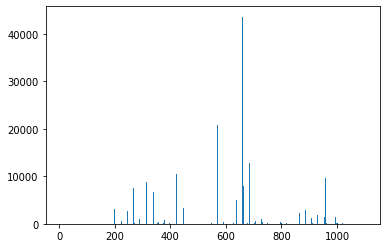

In [ ]:
plt.bar(data['latlon_section'].value_counts().index, data['latlon_section'].value_counts())

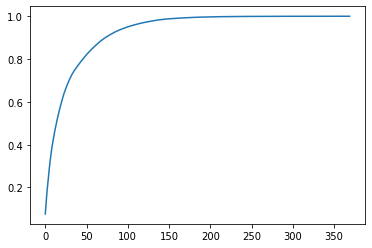

In [ ]:
counts = np.array(data['latlon_section'].value_counts())
counts_sum = counts.sum()
counts = np.sort(counts)[::-1]
plt.plot(np.arange(len(counts)), np.cumsum(counts) / counts_sum)

In [ ]:
## Train data generated by knn
id2index_d = dict(zip(data['id'].values, data.index))

tfidf_d = {}
for col in CFG.vec_columns:
    tfidf = TfidfVectorizer()
    tv_fit = tfidf.fit_transform(data[col].fillna('nan'))
    tfidf_d[col] = tv_fit

train_data = recall_knn(data, CFG.num_neighbors)

data = data.set_index('id')
ids = train_data['id'].tolist()
match_ids = train_data['match_id'].tolist()

poi = data.loc[ids]['point_of_interest'].values
match_poi = data.loc[match_ids]['point_of_interest'].values

train_data['label'] = np.array(poi == match_poi, dtype = np.int8)
del poi, match_poi, ids, match_ids
gc.collect()

print('Num of unique id: %s' % train_data['id'].nunique())
print('Num of train data: %s' % len(train_data))
print('Pos rate: %s' % train_data['label'].mean())
print(train_data.sample(5))

Start knn grouped by country


  0%|          | 0/370 [00:00<?, ?it/s]

Start knn
Num of unique id: 569406
Num of train data: 13273546
Pos rate: 0.0760047842528289
                        id          match_id     kdist  kneighbors  \
12835894  E_bba2cee1fe82e6  E_a632fe9fe99476       NaN         NaN   
3649966   E_68cbd28fb2dec8  E_65e4e9253bbbe2  0.002972         6.0   
4233317   E_6f2251639017a9  E_40b9c384871120  0.009543         7.0   
6358495   E_2aa08e50638a42  E_c14f0e3b75cd71  0.005964        11.0   
2791976   E_e72d1d671cf3f2  E_fcb5f5de269e2d  0.001256         4.0   

          kdist_country  kneighbors_country  label  
12835894       0.004305                17.0      0  
3649966        0.002844                 8.0      0  
4233317        0.009414                 7.0      0  
6358495        0.005512                14.0      0  
2791976        0.001029                 2.0      0  


In [ ]:
## Eval
data = data.reset_index()

id2poi = get_id2poi(data)
poi2ids = get_poi2ids(data)

eval_df = pd.DataFrame()
eval_df['id'] = data['id'].unique().tolist()
eval_df['match_id'] = eval_df['id']
print('Unique id: %s' % len(eval_df))

eval_df_ = train_data[train_data['label'] == 1][['id', 'match_id']]
eval_df = pd.concat([eval_df, eval_df_])

eval_df = eval_df.groupby('id')['match_id'].\
                        apply(list).reset_index()
eval_df['matches'] = eval_df['match_id'].apply(lambda x: ' '.join(set(x)))
print('Unique id: %s' % len(eval_df))

iou_score = get_score(eval_df)
print('IoU score: %s' % iou_score)

Unique id: 569406
Unique id: 569406
IoU score: 0.923328913265504


In [ ]:
distrs = [get_distribution(train_data["label"])]
index = ['training set']

for fold_ind, (dev_ind, val_ind) in enumerate(stratified_group_k_fold(train_data, train_data["label"], train_data["id"], k=CFG.num_split, seed=CFG.SEED)):
    train_data.loc[val_ind, "fold"] = fold_ind

    dev_y, val_y = train_data.loc[dev_ind, "label"], train_data.loc[val_ind, "label"]
    dev_groups, val_groups = train_data.loc[dev_ind, "id"], train_data.loc[val_ind, "id"]
    
    assert len(set(dev_groups) & set(val_groups)) == 0
    
    distrs.append(get_distribution(dev_y))
    index.append(f'development set - fold {fold_ind}')
    distrs.append(get_distribution(val_y))
    index.append(f'validation set - fold {fold_ind}')

display('Distribution per class:')
pd.DataFrame(distrs, index=index, columns=[f'Label {l}' for l in range(np.max(train_data["label"]) + 1)])

'Distribution per class:'

,Label 0,Label 1
training set,92.40%,7.60%
development set - fold 0,92.40%,7.60%
validation set - fold 0,92.40%,7.60%
development set - fold 1,92.40%,7.60%
validation set - fold 1,92.40%,7.60%
development set - fold 2,92.40%,7.60%
validation set - fold 2,92.40%,7.60%
development set - fold 3,92.40%,7.60%
validation set - fold 3,92.40%,7.60%
development set - fold 4,92.40%,7.60%


# model learning

In [ ]:
data = data.set_index('id')
train_data = add_features(train_data)

  0%|          | 0/9 [00:00<?, ?it/s]

In [ ]:
train_data['kdist_diff'] = (train_data['kdist'] - train_data['kdist_country']) /\
                            train_data['kdist_country']
train_data['kneighbors_mean'] = train_data[['kneighbors', 'kneighbors_country']].mean(axis = 1)

In [ ]:
features = ['kdist','kneighbors','kdist_country','kneighbors_country', 'kdist_diff', 'kneighbors_mean']

columns = ['name', 'address', 'city', 'state',
       'zip', 'country', 'url', 'phone', 'categories']

for c in columns:
    if c == 'country':
        features += ['country_leven', 'country_sim', 'country_gesh', 'country_nleven']
        continue
    features += [f"{c}_gesh", f"{c}_jaro", f"{c}_lcs", f"{c}_leven"]
    if c == 'city':
        features += [f"{c}_len_diff", f"{c}_nleven", f"{c}_nlcsk", f"{c}_nlcs"]
    if c in ['address', 'categories', 'country', 'name', 'state', 'url']:
        features += [f"{c}_len_diff", f"{c}_nleven", f"{c}_nlcsk", f"{c}_nlcs", f"{c}_sim"]

print(len(features))
print(features)

71
['kdist', 'kneighbors', 'kdist_country', 'kneighbors_country', 'kdist_diff', 'kneighbors_mean', 'name_gesh', 'name_jaro', 'name_lcs', 'name_leven', 'name_len_diff', 'name_nleven', 'name_nlcsk', 'name_nlcs', 'name_sim', 'address_gesh', 'address_jaro', 'address_lcs', 'address_leven', 'address_len_diff', 'address_nleven', 'address_nlcsk', 'address_nlcs', 'address_sim', 'city_gesh', 'city_jaro', 'city_lcs', 'city_leven', 'city_len_diff', 'city_nleven', 'city_nlcsk', 'city_nlcs', 'state_gesh', 'state_jaro', 'state_lcs', 'state_leven', 'state_len_diff', 'state_nleven', 'state_nlcsk', 'state_nlcs', 'state_sim', 'zip_gesh', 'zip_jaro', 'zip_lcs', 'zip_leven', 'country_leven', 'country_sim', 'country_gesh', 'country_nleven', 'url_gesh', 'url_jaro', 'url_lcs', 'url_leven', 'url_len_diff', 'url_nleven', 'url_nlcsk', 'url_nlcs', 'url_sim', 'phone_gesh', 'phone_jaro', 'phone_lcs', 'phone_leven', 'categories_gesh', 'categories_jaro', 'categories_lcs', 'categories_leven', 'categories_len_diff', 'c

In [ ]:
def fit_lgb(X, y, params=None, es_rounds=20, seed=42, N_SPLITS=5, 
             n_class=None, model_dir=None, folds=None):
    models = []
    oof = np.zeros((len(y), 2), dtype=np.float64)
    
    for i in tqdm(range(CFG.num_split)):
        print(f"== fold {i} ==")
        trn_idx = folds!=i
        val_idx = folds==i
        X_train, y_train = X[trn_idx], y.iloc[trn_idx]
        X_valid, y_valid = X.iloc[val_idx], y.iloc[val_idx]

        if model_dir is None:
            model = lgb.LGBMClassifier(**params)
            model.fit(
                X_train, y_train, 
                eval_set=[(X_valid, y_valid)],  
                early_stopping_rounds=es_rounds, 
                eval_metric='binary',  
    #             verbose=-1)
                verbose=50)
        else:
            with open(f'{model_dir}/lgb_fold{i}.pkl', 'rb') as f:
                model = pickle.load(f)
            
        pred = model.predict_proba(X_valid)
        oof[val_idx] = pred
        models.append(model)
        
        file = os.path.join(CFG.OUTPUT_DIR, os.path.join(CFG.expID, f'lgb_fold{i}.pkl'))
        pickle.dump(model, open(file, 'wb'))
        print()

    cv = (oof.argmax(axis=-1) == y).mean()
    print(f"CV-accuracy: {cv}")

    return oof, models

def inference_lgb(models, feat_df):
    pred = np.array([model.predict_proba(feat_df) for model in models])
    pred = np.mean(pred, axis=0)
    return pred

In [ ]:
params = {
    'objective': "binary",
    'learning_rate': 0.2,
    'reg_alpha': 0.1,
    'reg_lambda': 0.1,
    'random_state': 42,

    'max_depth': 7,   
    'num_leaves': 35, 
    'n_estimators': 1000000, 
    "colsample_bytree": 0.9,
}


oof, models = fit_lgb(train_data[features], train_data["label"].astype(int), 
                      params=params, n_class=2, 
                      N_SPLITS=CFG.num_split, folds=train_data["fold"].values)

  0%|          | 0/5 [00:00<?, ?it/s]

== fold 0 ==
[50]	valid_0's binary_logloss: 0.0463736
[100]	valid_0's binary_logloss: 0.0444643
[150]	valid_0's binary_logloss: 0.04358
[200]	valid_0's binary_logloss: 0.042947
[250]	valid_0's binary_logloss: 0.0424804
[300]	valid_0's binary_logloss: 0.0421217
[350]	valid_0's binary_logloss: 0.0417082
[400]	valid_0's binary_logloss: 0.0413718
[450]	valid_0's binary_logloss: 0.0410659
[500]	valid_0's binary_logloss: 0.0408149
[550]	valid_0's binary_logloss: 0.0405497
[600]	valid_0's binary_logloss: 0.0402825
[650]	valid_0's binary_logloss: 0.0400215
[700]	valid_0's binary_logloss: 0.0398497
[750]	valid_0's binary_logloss: 0.0396174
[800]	valid_0's binary_logloss: 0.0394351
[850]	valid_0's binary_logloss: 0.0392544
[900]	valid_0's binary_logloss: 0.039094
[950]	valid_0's binary_logloss: 0.0389416
[1000]	valid_0's binary_logloss: 0.0387351
[1050]	valid_0's binary_logloss: 0.0385979
[1100]	valid_0's binary_logloss: 0.0384563
[1150]	valid_0's binary_logloss: 0.0382757
[1200]	valid_0's binar

In [ ]:
train_data["pred"] = oof[:, -1]

In [ ]:
out_df = pd.DataFrame()
out_df['id'] = train_data['id'].unique().tolist()
out_df['match_id'] = out_df['id']

#Check Feature Importances

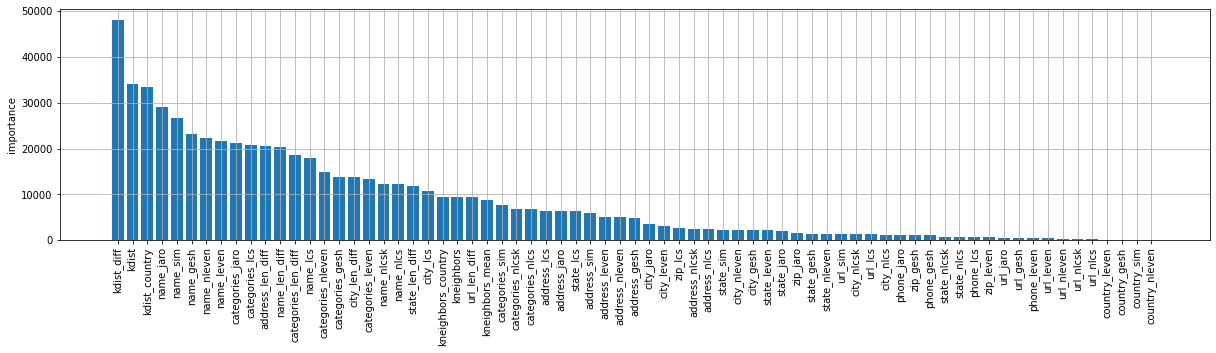

In [ ]:
def plot_importances(models):
    importance_df = pd.DataFrame(models[0].feature_importances_, 
                                 index=features, 
                                 columns=['importance'])\
                        .sort_values("importance", ascending=False)

    plt.subplots(figsize=(len(features) // 4, 5))
    plt.bar(importance_df.index, importance_df.importance)
    plt.grid()
    plt.xticks(rotation=90)
    plt.ylabel("importance")
    plt.tight_layout()
    plt.show()

plot_importances(models)

#Check CV

In [ ]:
!pip install optuna

     |████████████████████████████████| 308 kB 26.3 MB/s 
     |████████████████████████████████| 81 kB 9.2 MB/s 
     |████████████████████████████████| 210 kB 48.6 MB/s 
     |████████████████████████████████| 78 kB 5.9 MB/s 
     |████████████████████████████████| 49 kB 5.6 MB/s 
     |████████████████████████████████| 112 kB 72.7 MB/s 
     |████████████████████████████████| 146 kB 71.8 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11137 sha256=8fb4b13ef180f25885f86e40767e1412867a845028094b429c41b0bfaa31bd08
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip


In [ ]:
def post_process(df):
    id2match = dict(zip(df['id'].values, df['matches'].str.split()))

    for base, match in df[['id', 'matches']].values:
        match = match.split()
        if len(match) == 1:        
            continue

        for m in match:
            if base not in id2match[m]:
                id2match[m].append(base)
    df['matches'] = df['id'].map(id2match).map(' '.join)
    return df 

In [ ]:
import optuna

def objective(trial):
    x = trial.suggest_uniform('threshold', 0, 1)
    train_pred_df = train_data[train_data['pred'] > x][['id', 'match_id']]
    out_df = pd.DataFrame()
    out_df['id'] = train_data['id'].unique().tolist()
    out_df['match_id'] = out_df['id']
    out_df = pd.concat([out_df, train_pred_df])
    out_df = out_df.groupby('id')['match_id'].\
                        apply(list).reset_index()
    out_df['matches'] = out_df['match_id'].apply(lambda x: ' '.join(set(x)))
    out_df = post_process(out_df)

    score = get_score(out_df)
    print(f"CV: {score:.6f}")
    return score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

[I 2022-05-20 08:25:04,998] A new study created in memory with name: no-name-9ac44c4e-e165-4cd8-9f7a-98e46bc7bde6
[I 2022-05-20 08:26:00,957] Trial 0 finished with value: 0.8121164272203323 and parameters: {'threshold': 0.9748487566162312}. Best is trial 0 with value: 0.8121164272203323.


CV: 0.812116


[I 2022-05-20 08:26:23,862] Trial 1 finished with value: 0.8257757066082689 and parameters: {'threshold': 0.11124768234326521}. Best is trial 1 with value: 0.8257757066082689.


CV: 0.825776


[I 2022-05-20 08:26:43,311] Trial 2 finished with value: 0.8744048301393642 and parameters: {'threshold': 0.7374920255932434}. Best is trial 2 with value: 0.8744048301393642.


CV: 0.874405


[I 2022-05-20 08:27:04,152] Trial 3 finished with value: 0.8622957747081806 and parameters: {'threshold': 0.2577595472585962}. Best is trial 2 with value: 0.8744048301393642.


CV: 0.862296


[I 2022-05-20 08:27:24,130] Trial 4 finished with value: 0.8498792843178896 and parameters: {'threshold': 0.9089143346861862}. Best is trial 2 with value: 0.8744048301393642.


CV: 0.849879


[I 2022-05-20 08:27:44,395] Trial 5 finished with value: 0.8777432102610238 and parameters: {'threshold': 0.6641875079215158}. Best is trial 5 with value: 0.8777432102610238.


CV: 0.877743


[I 2022-05-20 08:28:04,994] Trial 6 finished with value: 0.8776849640061245 and parameters: {'threshold': 0.4769224673766622}. Best is trial 5 with value: 0.8777432102610238.


CV: 0.877685


[I 2022-05-20 08:28:24,495] Trial 7 finished with value: 0.8744139154501503 and parameters: {'threshold': 0.7372779525266858}. Best is trial 5 with value: 0.8777432102610238.


CV: 0.874414


[I 2022-05-20 08:28:46,298] Trial 8 finished with value: 0.7632116291050993 and parameters: {'threshold': 0.038108871523942045}. Best is trial 5 with value: 0.8777432102610238.


CV: 0.763212


[I 2022-05-20 08:29:06,974] Trial 9 finished with value: 0.8740018635708965 and parameters: {'threshold': 0.3845202231950182}. Best is trial 5 with value: 0.8777432102610238.


CV: 0.874002


[I 2022-05-20 08:29:26,483] Trial 10 finished with value: 0.8776525234832291 and parameters: {'threshold': 0.6672069129482627}. Best is trial 5 with value: 0.8777432102610238.


CV: 0.877653


[I 2022-05-20 08:29:46,950] Trial 11 finished with value: 0.8786086837601539 and parameters: {'threshold': 0.5139689010633822}. Best is trial 11 with value: 0.8786086837601539.


CV: 0.878609


[I 2022-05-20 08:30:07,430] Trial 12 finished with value: 0.8790281132550428 and parameters: {'threshold': 0.5852432282473977}. Best is trial 12 with value: 0.8790281132550428.


CV: 0.879028


[I 2022-05-20 08:30:27,081] Trial 13 finished with value: 0.8783882356311749 and parameters: {'threshold': 0.5042491446722643}. Best is trial 12 with value: 0.8790281132550428.


CV: 0.878388


[I 2022-05-20 08:30:47,485] Trial 14 finished with value: 0.8789669864811265 and parameters: {'threshold': 0.542833210851427}. Best is trial 12 with value: 0.8790281132550428.


CV: 0.878967


[I 2022-05-20 08:31:07,434] Trial 15 finished with value: 0.8716851893258144 and parameters: {'threshold': 0.3508615453216899}. Best is trial 12 with value: 0.8790281132550428.


CV: 0.871685


[I 2022-05-20 08:31:27,952] Trial 16 finished with value: 0.8790014826490455 and parameters: {'threshold': 0.5872063936379532}. Best is trial 12 with value: 0.8790281132550428.


CV: 0.879001


[I 2022-05-20 08:31:47,184] Trial 17 finished with value: 0.8650529159504192 and parameters: {'threshold': 0.8355275754758893}. Best is trial 12 with value: 0.8790281132550428.


CV: 0.865053


[I 2022-05-20 08:32:06,696] Trial 18 finished with value: 0.8787592946811458 and parameters: {'threshold': 0.6152652128198642}. Best is trial 12 with value: 0.8790281132550428.


CV: 0.878759


[I 2022-05-20 08:32:27,560] Trial 19 finished with value: 0.8643705690921867 and parameters: {'threshold': 0.27405694937143454}. Best is trial 12 with value: 0.8790281132550428.


CV: 0.864371


[I 2022-05-20 08:32:51,549] Trial 20 finished with value: 0.8695501706248737 and parameters: {'threshold': 0.7973013822288524}. Best is trial 12 with value: 0.8790281132550428.


CV: 0.869550


[I 2022-05-20 08:33:11,325] Trial 21 finished with value: 0.8790763160694224 and parameters: {'threshold': 0.5718574627709687}. Best is trial 21 with value: 0.8790763160694224.


CV: 0.879076


[I 2022-05-20 08:33:31,726] Trial 22 finished with value: 0.8788296421304985 and parameters: {'threshold': 0.6093555771927874}. Best is trial 21 with value: 0.8790763160694224.


CV: 0.878830


[I 2022-05-20 08:33:51,662] Trial 23 finished with value: 0.8753779847994684 and parameters: {'threshold': 0.410719663204176}. Best is trial 21 with value: 0.8790763160694224.


CV: 0.875378


[I 2022-05-20 08:34:11,325] Trial 24 finished with value: 0.8790455162425864 and parameters: {'threshold': 0.5665196145351129}. Best is trial 21 with value: 0.8790763160694224.


CV: 0.879046


[I 2022-05-20 08:34:31,753] Trial 25 finished with value: 0.8762206740813722 and parameters: {'threshold': 0.4315620842576843}. Best is trial 21 with value: 0.8790763160694224.


CV: 0.876221


[I 2022-05-20 08:34:51,146] Trial 26 finished with value: 0.8759699839534093 and parameters: {'threshold': 0.7104524165491829}. Best is trial 21 with value: 0.8790763160694224.


CV: 0.875970


[I 2022-05-20 08:35:12,066] Trial 27 finished with value: 0.8642687761480298 and parameters: {'threshold': 0.2732309438361787}. Best is trial 21 with value: 0.8790763160694224.


CV: 0.864269


[I 2022-05-20 08:35:32,455] Trial 28 finished with value: 0.8790553256767092 and parameters: {'threshold': 0.5627363524860354}. Best is trial 21 with value: 0.8790763160694224.


CV: 0.879055


[I 2022-05-20 08:35:52,110] Trial 29 finished with value: 0.8296054637163753 and parameters: {'threshold': 0.9550464074133878}. Best is trial 21 with value: 0.8790763160694224.


CV: 0.829605


[I 2022-05-20 08:36:11,530] Trial 30 finished with value: 0.8680345147182271 and parameters: {'threshold': 0.8119587325920309}. Best is trial 21 with value: 0.8790763160694224.


CV: 0.868035


[I 2022-05-20 08:36:31,191] Trial 31 finished with value: 0.8790594246517659 and parameters: {'threshold': 0.5615985113705348}. Best is trial 21 with value: 0.8790763160694224.


CV: 0.879059


[I 2022-05-20 08:36:51,968] Trial 32 finished with value: 0.8772750893647427 and parameters: {'threshold': 0.4659320690282125}. Best is trial 21 with value: 0.8790763160694224.


CV: 0.877275


[I 2022-05-20 08:37:12,414] Trial 33 finished with value: 0.8790949400863315 and parameters: {'threshold': 0.5582202827414949}. Best is trial 33 with value: 0.8790949400863315.


CV: 0.879095


[I 2022-05-20 08:37:32,338] Trial 34 finished with value: 0.8707599148270687 and parameters: {'threshold': 0.338229748608009}. Best is trial 33 with value: 0.8790949400863315.


CV: 0.870760


[I 2022-05-20 08:37:52,608] Trial 35 finished with value: 0.8777658777883403 and parameters: {'threshold': 0.6633676777938706}. Best is trial 33 with value: 0.8790949400863315.


CV: 0.877766


[I 2022-05-20 08:38:12,324] Trial 36 finished with value: 0.8787920739728273 and parameters: {'threshold': 0.5292577860150051}. Best is trial 33 with value: 0.8790949400863315.


CV: 0.878792


[I 2022-05-20 08:38:32,810] Trial 37 finished with value: 0.8769392514744201 and parameters: {'threshold': 0.4536852183550065}. Best is trial 33 with value: 0.8790949400863315.


CV: 0.876939


[I 2022-05-20 08:38:53,039] Trial 38 finished with value: 0.8780423174369509 and parameters: {'threshold': 0.6519002456551701}. Best is trial 33 with value: 0.8790949400863315.


CV: 0.878042


[I 2022-05-20 08:39:14,154] Trial 39 finished with value: 0.8459889748219767 and parameters: {'threshold': 0.17088077215747505}. Best is trial 33 with value: 0.8790949400863315.


CV: 0.845989


[I 2022-05-20 08:39:33,629] Trial 40 finished with value: 0.8709508910815075 and parameters: {'threshold': 0.783718759187765}. Best is trial 33 with value: 0.8790949400863315.


CV: 0.870951


[I 2022-05-20 08:39:53,472] Trial 41 finished with value: 0.8789397205029906 and parameters: {'threshold': 0.5967983176594114}. Best is trial 33 with value: 0.8790949400863315.


CV: 0.878940


[I 2022-05-20 08:40:13,701] Trial 42 finished with value: 0.8790867540383213 and parameters: {'threshold': 0.5574294238485131}. Best is trial 33 with value: 0.8790949400863315.


CV: 0.879087


[I 2022-05-20 08:40:33,949] Trial 43 finished with value: 0.8761774687794694 and parameters: {'threshold': 0.7061052482606492}. Best is trial 33 with value: 0.8790949400863315.


CV: 0.876177


[I 2022-05-20 08:40:54,590] Trial 44 finished with value: 0.8783596291938292 and parameters: {'threshold': 0.5026419791745884}. Best is trial 33 with value: 0.8790949400863315.


CV: 0.878360


[I 2022-05-20 08:41:14,273] Trial 45 finished with value: 0.8790812026207645 and parameters: {'threshold': 0.5552309474119543}. Best is trial 33 with value: 0.8790949400863315.


CV: 0.879081


[I 2022-05-20 08:41:34,848] Trial 46 finished with value: 0.8739116841615284 and parameters: {'threshold': 0.3827932290074513}. Best is trial 33 with value: 0.8790949400863315.


CV: 0.873912


[I 2022-05-20 08:41:54,512] Trial 47 finished with value: 0.8785584341557923 and parameters: {'threshold': 0.6249474360879458}. Best is trial 33 with value: 0.8790949400863315.


CV: 0.878558


[I 2022-05-20 08:42:14,635] Trial 48 finished with value: 0.8736808753733821 and parameters: {'threshold': 0.7489596957721274}. Best is trial 33 with value: 0.8790949400863315.


CV: 0.873681


[I 2022-05-20 08:42:35,080] Trial 49 finished with value: 0.8781274478702058 and parameters: {'threshold': 0.49191740468674694}. Best is trial 33 with value: 0.8790949400863315.


CV: 0.878127


[I 2022-05-20 08:42:54,456] Trial 50 finished with value: 0.8770682673927935 and parameters: {'threshold': 0.6835646835337553}. Best is trial 33 with value: 0.8790949400863315.


CV: 0.877068


[I 2022-05-20 08:43:14,919] Trial 51 finished with value: 0.8790644530585071 and parameters: {'threshold': 0.5487366677126597}. Best is trial 33 with value: 0.8790949400863315.


CV: 0.879064


[I 2022-05-20 08:43:34,614] Trial 52 finished with value: 0.8787474632928192 and parameters: {'threshold': 0.5225661209260628}. Best is trial 33 with value: 0.8790949400863315.


CV: 0.878747


[I 2022-05-20 08:43:54,126] Trial 53 finished with value: 0.8790474086584676 and parameters: {'threshold': 0.5631309351735065}. Best is trial 33 with value: 0.8790949400863315.


CV: 0.879047


[I 2022-05-20 08:44:14,337] Trial 54 finished with value: 0.8784696249239571 and parameters: {'threshold': 0.6316968595724775}. Best is trial 33 with value: 0.8790949400863315.


CV: 0.878470


[I 2022-05-20 08:44:34,859] Trial 55 finished with value: 0.8770378112757289 and parameters: {'threshold': 0.4579585276027276}. Best is trial 33 with value: 0.8790949400863315.


CV: 0.877038


[I 2022-05-20 08:44:56,722] Trial 56 finished with value: 0.8751858661692731 and parameters: {'threshold': 0.4056003359375365}. Best is trial 33 with value: 0.8790949400863315.


CV: 0.875186


[I 2022-05-20 08:45:16,324] Trial 57 finished with value: 0.879062914250315 and parameters: {'threshold': 0.5485001506158383}. Best is trial 33 with value: 0.8790949400863315.


CV: 0.879063


[I 2022-05-20 08:45:35,887] Trial 58 finished with value: 0.878791466644234 and parameters: {'threshold': 0.5320715709575968}. Best is trial 33 with value: 0.8790949400863315.


CV: 0.878791


[I 2022-05-20 08:45:56,154] Trial 59 finished with value: 0.8780584679099321 and parameters: {'threshold': 0.48904186605421635}. Best is trial 33 with value: 0.8790949400863315.


CV: 0.878058


[I 2022-05-20 08:46:15,847] Trial 60 finished with value: 0.872002653769068 and parameters: {'threshold': 0.35455000173811413}. Best is trial 33 with value: 0.8790949400863315.


CV: 0.872003


[I 2022-05-20 08:46:35,989] Trial 61 finished with value: 0.8790238913691455 and parameters: {'threshold': 0.581686389669094}. Best is trial 33 with value: 0.8790949400863315.


CV: 0.879024


[I 2022-05-20 08:46:56,358] Trial 62 finished with value: 0.8790789649971741 and parameters: {'threshold': 0.5510839177498986}. Best is trial 33 with value: 0.8790949400863315.


CV: 0.879079


[I 2022-05-20 08:47:16,583] Trial 63 finished with value: 0.8783679244725617 and parameters: {'threshold': 0.6394787024945883}. Best is trial 33 with value: 0.8790949400863315.


CV: 0.878368


[I 2022-05-20 08:47:36,298] Trial 64 finished with value: 0.876348228535945 and parameters: {'threshold': 0.4352734673283461}. Best is trial 33 with value: 0.8790949400863315.


CV: 0.876348


[I 2022-05-20 08:47:55,681] Trial 65 finished with value: 0.8789398865252851 and parameters: {'threshold': 0.5953991578760753}. Best is trial 33 with value: 0.8790949400863315.


CV: 0.878940


[I 2022-05-20 08:48:15,989] Trial 66 finished with value: 0.8790228791407321 and parameters: {'threshold': 0.5466235252349705}. Best is trial 33 with value: 0.8790949400863315.


CV: 0.879023


[I 2022-05-20 08:48:36,189] Trial 67 finished with value: 0.8768232737392556 and parameters: {'threshold': 0.6901331439928742}. Best is trial 33 with value: 0.8790949400863315.


CV: 0.876823


[I 2022-05-20 08:48:56,272] Trial 68 finished with value: 0.8780648416881704 and parameters: {'threshold': 0.48924380023741215}. Best is trial 33 with value: 0.8790949400863315.


CV: 0.878065


[I 2022-05-20 08:49:16,206] Trial 69 finished with value: 0.8787747993137649 and parameters: {'threshold': 0.6114395090417595}. Best is trial 33 with value: 0.8790949400863315.


CV: 0.878775


[I 2022-05-20 08:49:36,443] Trial 70 finished with value: 0.8748841182728067 and parameters: {'threshold': 0.730109730647172}. Best is trial 33 with value: 0.8790949400863315.


CV: 0.874884


[I 2022-05-20 08:49:56,108] Trial 71 finished with value: 0.8790771813374421 and parameters: {'threshold': 0.5541463998232081}. Best is trial 33 with value: 0.8790949400863315.


CV: 0.879077


[I 2022-05-20 08:50:16,647] Trial 72 finished with value: 0.8787973547514722 and parameters: {'threshold': 0.5264319497503309}. Best is trial 33 with value: 0.8790949400863315.


CV: 0.878797


[I 2022-05-20 08:50:36,230] Trial 73 finished with value: 0.8790389895978746 and parameters: {'threshold': 0.5743956781002241}. Best is trial 33 with value: 0.8790949400863315.


CV: 0.879039


[I 2022-05-20 08:50:56,351] Trial 74 finished with value: 0.8790798680635078 and parameters: {'threshold': 0.5497538226047011}. Best is trial 33 with value: 0.8790949400863315.


CV: 0.879080


[I 2022-05-20 08:51:16,598] Trial 75 finished with value: 0.8785414704996095 and parameters: {'threshold': 0.5116999078189371}. Best is trial 33 with value: 0.8790949400863315.


CV: 0.878541


[I 2022-05-20 08:51:37,104] Trial 76 finished with value: 0.877365863905404 and parameters: {'threshold': 0.46938117780899974}. Best is trial 33 with value: 0.8790949400863315.


CV: 0.877366


[I 2022-05-20 08:51:56,605] Trial 77 finished with value: 0.8780533944363882 and parameters: {'threshold': 0.6517104545987117}. Best is trial 33 with value: 0.8790949400863315.


CV: 0.878053


[I 2022-05-20 08:52:16,313] Trial 78 finished with value: 0.8764308123390526 and parameters: {'threshold': 0.43801171295273167}. Best is trial 33 with value: 0.8790949400863315.


CV: 0.876431


[I 2022-05-20 08:52:36,490] Trial 79 finished with value: 0.8788922358681954 and parameters: {'threshold': 0.6071484439273953}. Best is trial 33 with value: 0.8790949400863315.


CV: 0.878892


[I 2022-05-20 08:52:57,922] Trial 80 finished with value: 0.7495356840113773 and parameters: {'threshold': 0.0310876078339431}. Best is trial 33 with value: 0.8790949400863315.


CV: 0.749536


[I 2022-05-20 08:53:19,332] Trial 81 finished with value: 0.8790143984000438 and parameters: {'threshold': 0.5808224962653707}. Best is trial 33 with value: 0.8790949400863315.


CV: 0.879014


[I 2022-05-20 08:53:38,881] Trial 82 finished with value: 0.8790503093409503 and parameters: {'threshold': 0.5479639500468958}. Best is trial 33 with value: 0.8790949400863315.


CV: 0.879050


[I 2022-05-20 08:53:59,117] Trial 83 finished with value: 0.8790268208889076 and parameters: {'threshold': 0.5467445407579427}. Best is trial 33 with value: 0.8790949400863315.


CV: 0.879027


[I 2022-05-20 08:54:19,390] Trial 84 finished with value: 0.8786521676872527 and parameters: {'threshold': 0.5174262218597903}. Best is trial 33 with value: 0.8790949400863315.


CV: 0.878652


[I 2022-05-20 08:54:38,896] Trial 85 finished with value: 0.8785032433497147 and parameters: {'threshold': 0.6299876831846746}. Best is trial 33 with value: 0.8790949400863315.


CV: 0.878503


[I 2022-05-20 08:54:58,961] Trial 86 finished with value: 0.8773555511371222 and parameters: {'threshold': 0.6765881799790671}. Best is trial 33 with value: 0.8790949400863315.


CV: 0.877356


[I 2022-05-20 08:55:19,586] Trial 87 finished with value: 0.8776061424094401 and parameters: {'threshold': 0.47497809116421097}. Best is trial 33 with value: 0.8790949400863315.


CV: 0.877606


[I 2022-05-20 08:55:39,175] Trial 88 finished with value: 0.8790885108689789 and parameters: {'threshold': 0.5585780446075552}. Best is trial 33 with value: 0.8790949400863315.


CV: 0.879089


[I 2022-05-20 08:55:59,390] Trial 89 finished with value: 0.8789454793094506 and parameters: {'threshold': 0.5955826174712663}. Best is trial 33 with value: 0.8790949400863315.


CV: 0.878945


[I 2022-05-20 08:56:19,110] Trial 90 finished with value: 0.8751846643207923 and parameters: {'threshold': 0.4054356463150028}. Best is trial 33 with value: 0.8790949400863315.


CV: 0.875185


[I 2022-05-20 08:56:38,553] Trial 91 finished with value: 0.8790871258395052 and parameters: {'threshold': 0.5500636755109994}. Best is trial 33 with value: 0.8790949400863315.


CV: 0.879087


[I 2022-05-20 08:56:58,728] Trial 92 finished with value: 0.8783862435867684 and parameters: {'threshold': 0.5045705858066096}. Best is trial 33 with value: 0.8790949400863315.


CV: 0.878386


[I 2022-05-20 08:57:18,995] Trial 93 finished with value: 0.8790654838349072 and parameters: {'threshold': 0.5675109740348453}. Best is trial 33 with value: 0.8790949400863315.


CV: 0.879065


[I 2022-05-20 08:57:39,319] Trial 94 finished with value: 0.8790163184530789 and parameters: {'threshold': 0.5783057594034362}. Best is trial 33 with value: 0.8790949400863315.


CV: 0.879016


[I 2022-05-20 08:57:59,896] Trial 95 finished with value: 0.8068800189283891 and parameters: {'threshold': 0.0779875174411408}. Best is trial 33 with value: 0.8790949400863315.


CV: 0.806880


[I 2022-05-20 08:58:20,000] Trial 96 finished with value: 0.8786134278157002 and parameters: {'threshold': 0.6220778659713098}. Best is trial 33 with value: 0.8790949400863315.


CV: 0.878613


[I 2022-05-20 08:58:40,161] Trial 97 finished with value: 0.8779474476877405 and parameters: {'threshold': 0.6561768873607577}. Best is trial 33 with value: 0.8790949400863315.


CV: 0.877947


[I 2022-05-20 08:58:59,555] Trial 98 finished with value: 0.8790871374689673 and parameters: {'threshold': 0.5582876575588341}. Best is trial 33 with value: 0.8790949400863315.


CV: 0.879087


[I 2022-05-20 08:59:19,908] Trial 99 finished with value: 0.8787426143848661 and parameters: {'threshold': 0.5212793538018267}. Best is trial 33 with value: 0.8790949400863315.


CV: 0.878743


In [ ]:
threshold = study.best_params['threshold']
threshold

0.5582202827414949

In [ ]:
study.best_value

0.8790949400863315

In [ ]:
train_pred_df = train_data[train_data['pred'] > threshold][['id', 'match_id']]
out_df = pd.DataFrame()
out_df['id'] = train_data['id'].unique().tolist()
out_df['match_id'] = out_df['id']
out_df = pd.concat([out_df, train_pred_df])
out_df = out_df.groupby('id')['match_id'].\
                    apply(list).reset_index()
out_df['matches'] = out_df['match_id'].apply(lambda x: ' '.join(set(x)))
out_df = post_process(out_df)

score = get_score(out_df)
print(f"CV: {score:.6f}")

CV: 0.879095
